#Instalaciones Previas

In [ ]:
!pip3 install dwave-neal
!pip3 install qubovert
!pip3 install dwave-system

In [ ]:

import qubovert
import math
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from time import time
import math as math


#Funciones auxiliares y Parámetros


En este apartado definimos diferentes funciones auxiliares que usaremos a lo largo de la implementación, así como los parámetros para la ejecución del problema.

###Funciones auxiliares

*toNumpy*: setrata de una función a la que dado un valor lo transformará a un array de Numpy

In [ ]:
#Pasamos a np
def toNumpy(v):
    return np.sqrt(np.sum(v**2))

###Definición de parámetros


***-N***: número de nodos que tendrá el problema.

***-R***: como hemos visto en la modelización del problema en la memoria, las variables pueden tener 3 valores diferentes (0,1,2). Por ello establecemos R=3.

***-penalización***: es el valor por el que multiplicamos los distintos coeficientes de Lagrange, y que así tomen valores grandes, con el fin de conseguir resultados correctos en la ejecución del problema.

***-lis_r***: se trata de una lista de dimensión R (3) que nos facilitará la imprementación a la hora de establecer las restricciones del problema.

***-lis_n***: al igual que en el caso anterior, una lista que usaremos como índices en los sumatorios de las distintas restricciones.

In [ ]:
N = 8
R=3
penalizacion = 2
lis_r = range(R)
lis_n = range(0,N+1)


#Representación del problema

Para la creación del problema, creamos los distintos puntos que representan los distintos nodos o ciudades que nuestro problema debe recorrer. La última ciudad que se debe visitar se corresponde con la inicial y por lo tanto, no está incluida en el valor $N$.

Los nodos del problema son:
[[0.65894762 0.88281972]
 [0.56238378 0.65362786]
 [0.99197631 0.56036421]
 [0.71332297 0.86069822]
 [0.65894762 0.88281972]]


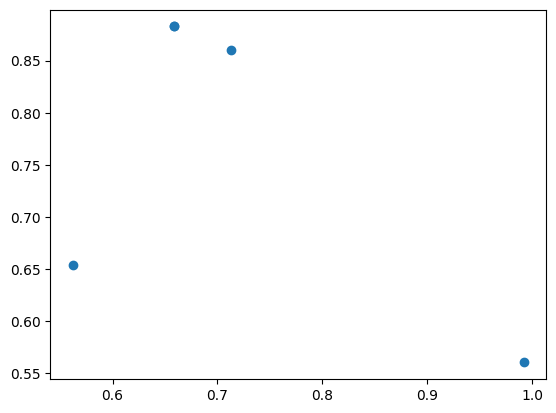

In [ ]:
puntos = np.random.rand(N+1,2)
puntos[N]=puntos[0]

print("Los nodos del problema son:")
print(puntos)
plt.plot(puntos[:,0],puntos[:,1],'o')


[[   0.  363.  343.  489.  428.  456.  262.  690.    0.    0.]
 [ 363.    0.  399.  829.  714.   93.  312. 1052.  363.  363.]
 [ 343.  399.    0.  782.  763.  457.  541.  903.  343.  343.]
 [ 489.  829.  782.    0.  198.  920.  576.  292.  489.  489.]
 [ 428.  714.  763.  198.    0.  800.  426.  490.  428.  428.]
 [ 456.   93.  457.  920.  800.    0.  386. 1145.  456.  456.]
 [ 262.  312.  541.  576.  426.  386.    0.  841.  262.  262.]
 [ 690. 1052.  903.  292.  490. 1145.  841.    0.  690.  690.]
 [   0.  363.  343.  489.  428.  456.  262.  690.    0.    0.]
 [   0.  363.  343.  489.  428.  456.  262.  690.    0.    0.]]


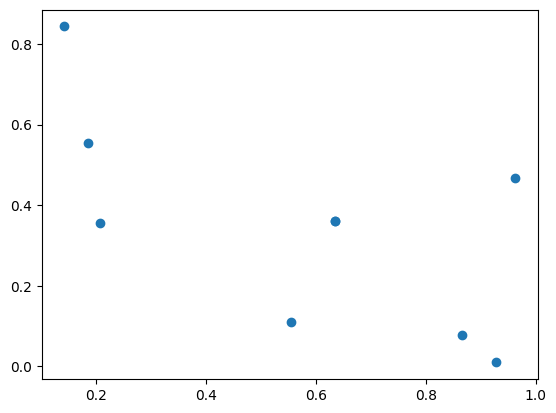

In [ ]:
plt.plot(puntos[:,0],puntos[:,1],'o')
distancia = np.zeros((N+2,N+2))
for i in range(N):
    for j in range(i+1,N+1):
        aux  =  toNumpy(puntos[i,:]-puntos[j,:])
        distancia[i,j],distancia[j,i] = aux,aux

for j in range(0,N+1):
    i = N+1
    aux  =  toNumpy(puntos[0,:]-puntos[j,:])
    distancia[i,j],distancia[j,i] = aux,aux
distancia = np.floor(distancia*1000)
print(distancia)

### Matriz distancia.
Se trata de una matriz que guarda las distancia desde una ciudad a todas las demás. De este modo, podremos usar esta matriz para obtener el camíno mínimo a recorrer entre todos los puntos. Para una mejor lectura, normalizamos la distancia.

In [ ]:
distancia = np.zeros((N+1,N+1))
for i in range(N):
    for j in range(i+1,N+1):
        aux  =  toNumpy(puntos[i,:]-puntos[j,:])
        distancia[i,j],distancia[j,i] = aux,aux
distancia = np.floor(distancia*1000)
print(distancia)


[[   0.  363.  343.  489.  428.  456.  262.  690.    0.]
 [ 363.    0.  399.  829.  714.   93.  312. 1052.  363.]
 [ 343.  399.    0.  782.  763.  457.  541.  903.  343.]
 [ 489.  829.  782.    0.  198.  920.  576.  292.  489.]
 [ 428.  714.  763.  198.    0.  800.  426.  490.  428.]
 [ 456.   93.  457.  920.  800.    0.  386. 1145.  456.]
 [ 262.  312.  541.  576.  426.  386.    0.  841.  262.]
 [ 690. 1052.  903.  292.  490. 1145.  841.    0.  690.]
 [   0.  363.  343.  489.  428.  456.  262.  690.    0.]]


Según la tabla de distancias obtenida anteriormente, obtenemos el camino más corto entre los vecinos cercanos y calculamos la distancia de dicho camino. Es decir tras visitar un nodo $i$, el siguiente nodo a visitar será el $j$ que esté mas cerca de ese primero.

El valor de la distancia de este camino, representa una primera solución a nuestro problema.

In [ ]:
distanciaAux  = np.copy(distancia)
for i in lis_n:
    distanciaAux[i,i] = np.inf
distanciaAux = np.copy(distanciaAux[:-1,:-1])
i = 0
distanciaMin = 0
ordenRecorrido = [i]
for j in range(N):
    distanciaAux[j,0] = np.inf
for cont in range(N-1):
    siguienteDistancia = np.min(distanciaAux[i,:])
    distanciaMin += siguienteDistancia
    sig = np.where(distanciaAux[i,:] == siguienteDistancia)[0][0]
    for j in range(N):
        distanciaAux[j,sig] = np.inf #Actualizamos distancia para que no vuelva a ese nodo
    i = sig
    ordenRecorrido.append(i)
distanciaMin += distancia[ordenRecorrido[-1],0]
#El último nodo es el mismo que el primero.
ordenRecorrido.append(0)

print("El orden recorrido es:", ordenRecorrido)
print("La distancia recorrida es:", distanciaMin)

El orden recorrido es: [0, 6, 1, 5, 2, 4, 3, 7, 0]
La distancia recorrida es: 3067.0


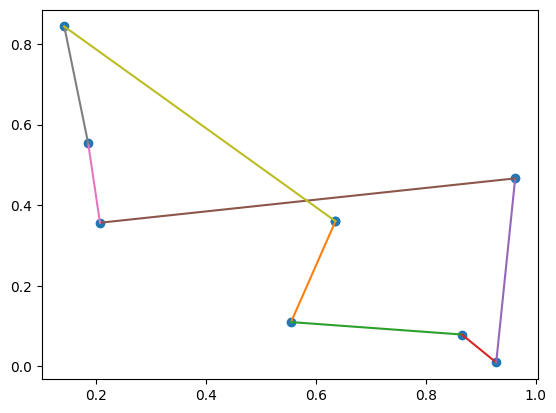

El orden recorrido es: [0, 6, 1, 5, 2, 4, 3, 7, 0]
La distancia recorrida es: 3067.0


In [ ]:
plt.plot(puntos[:,0],puntos[:,1],'o')
for i in range(N):
    plt.plot(puntos[(ordenRecorrido[i],ordenRecorrido[i+1]),0],puntos[(ordenRecorrido[i],ordenRecorrido[i+1]),1])
plt.show()
print("El orden recorrido es:", ordenRecorrido)
print("La distancia recorrida es:", distanciaMin)

#Modelo


## Variables del modelo
La clase ***qubovert.QUBO()*** es una implementación de QUBO en Python que proporciona una interfaz conveniente para definir y manipular problemas de optimización en forma de QUBO. Esta clase permite construir la matriz QUBO y realizar diversas operaciones sobre ella.

Como sabemos, nuestras variables son de la forma ***f x_{i,j,r}***, usaremos el método **create_var()** para crear las variablesde nuestro problema.

In [ ]:
# Creamos las variables del modelo
coef = qubovert.QUBO()

## Variables x_{i,j,r}
for i in lis_n:
    for j in lis_n:
        if not i==j:
            for r in lis_r:
                coef.create_var(f"x_{i}_{j}_{r}")

numVariables = len(lis_n)*len(lis_n)*len(lis_r)
print("Usaremos:", numVariables,"variables")

Usaremos: 243 variables


## Añadimos las restricciones
De acuerdo a las distintas restricciones que hemos definido en la memoria, calculamos los valores que tendrán cada una de nuestras variables de acuerdo a los distintos coeficientes de Lagrnage (también definidos en la memoria).


### Restricción 1:
Función de penalización:
\begin{equation*}
            \sum_{i=0}^{N+1}\sum_{j=0}^{N+1}( \sum_{r_1=0}^{2}\sum_{r_2=0}^{2}\lambda_1 x_{i,j,r_1}x_{i,j,r_2}+\sum_{r=0}^{2}-2\lambda_1 x_{i,j,r})
\end{equation*}
Coeficiente de Lagrange:
\begin{equation*}
        \lambda_1 > D
        \end{equation*}

In [ ]:
lagrange_1 = distanciaMin*penalizacion
for i in lis_n:
    for j in lis_n:
        if not i==j:
            for r1 in lis_r:
                for r2 in lis_r:
                    coef[(f"x_{i}_{j}_{r1}",f"x_{i}_{j}_{r2}")] += (lagrange_1)
            for r in lis_r:
                    coef[(f"x_{i}_{j}_{r}",)] += -2*(lagrange_1)

### Restricción 2:
Función de penalización:
\begin{equation*}
            \sum_{i=0}^{N}(\sum_{j_1=0}^{N+1}\sum_{j_2=0}^{N+1}\lambda_2 x_{i,j_1,1}x_{i,j_2,1}+\sum_{j=0}^{N}-2\lambda_2 x_{i,j,1})
        \end{equation*}
Coeficiente de Lagrange:
        \begin{equation*}
        \textrm{Para todo } j \epsilon [1,\dots,N] \textrm{ }
        \lambda_2 > max\textrm{ }d_{i,j}
        \end{equation*}

In [ ]:
for i in range(N+1):
    lagrange_2 =penalizacion*np.max(distancia[i,])
    for j in lis_n:
        if not i == j:
            coef[(f"x_{i}_{j}_{1}",)] += -2*lagrange_2
    for j1 in  lis_n:
        if j1 != i:
            for j2 in lis_n:
                if j2!=i:
                    coef[(f"x_{i}_{j1}_{1}",f"x_{i}_{j2}_{1}")]+= lagrange_2

### Restricción 3:
Función de penalización:
\begin{equation*}
            \sum_{j=1}^{N+1}(\sum_{i_1=1}^{N}\sum_{i_2=1}^{N}\lambda_3 x_{i_1,j,1}x_{i_2,j,1}+\sum_{i=1}^{N}-2\lambda_3 x_{i,j,1})
        \end{equation*}
Coeficiente de Lagrange:
        \begin{equation*}
        \textrm{Para todo } i \epsilon [0,\dots,N+1] \textrm{ }
        \lambda_3 > max\textrm{ }d_{i,j}
        \end{equation*}

In [ ]:
for j in range(1,N+1):
    lagrange_3 = penalizacion*np.max(distancia[:,j])
    for i1 in  lis_n:
        if i1!=j:
            for i2 in lis_n:
                if i2!=j:
                    coef[(f"x_{i1}_{j}_{1}",f"x_{i2}_{j}_{1}")]+= lagrange_3
    for i in range(N+1):
        if i!=j:
            coef[(f"x_{i}_{j}_{1}",)] += -2*lagrange_3

### Restricción 4:
Función de penalización:
\begin{equation*}
            \sum_{j=0}^{N+1} \lambda_4x_{0,j,2}
        \end{equation*}
Coeficiente de Lagrange:
        \begin{equation*}
        \textrm{Para todo } j \epsilon [0,\dots,N+1] \textrm{ }
        \lambda_5 > max\textrm{ }d_{0,j}
        \end{equation*}

In [ ]:
for j in lis_n:
  lagrange_4 = penalizacion*np.max(distancia[0,j])
  coef[(f"x_{0}_{j}_{2}",)] += lagrange_4

### Restricción 5:
Función de penalización:
\begin{equation*}
            \sum_{i=0}^{N+1} \lambda_5x_{i,N+1,2}
        \end{equation*}
Coeficiente de Lagrange:
        \begin{equation*}
        \textrm{Para todo } j \epsilon [1,\dots,N] \textrm{ }
        \lambda_5 > max\textrm{ }d_{j,N+1}
        \end{equation*}

In [ ]:
for i in lis_n:
  lagrange_5 = penalizacion*np.max(distancia[i,0])
  coef[(f"x_{i}_{N+1}_{2}",)] += lagrange_5

### Restricción 6:
Función de penalización:
\begin{equation*}
            \sum_{i=0}^{N+1} \lambda_6x_{i,i}
        \end{equation*}
Coeficiente de Lagrange:
        \begin{equation*}
        \textrm{Para todo } j \epsilon [0,\dots,N+1]\textrm{ }
        \lambda_6 > max\textrm{ }(max\textrm{ } d_{i,j}, max\textrm{ } d_{j,i})
        \end{equation*}

In [ ]:
for i in lis_n:
  lagrange_6 = penalizacion*max(np.max(distancia[i,j]),np.max(distancia[j,i]))
  coef[(f"x_{i}_{i}_{1}",)] += lagrange_6

###Restrcción 7:
Función de penalización:
\begin{equation*}
            \sum_{i\neq j} (2\lambda_7 x_{i,j,2}x_{j,i,2}-\lambda_7 x_{i,j,2}-\lambda_7x_{j,i,2})
        \end{equation*}
Coeficiente de Lagrange:
        \begin{equation*}
        \lambda_7 > D
        \end{equation*}

In [ ]:
lagrange_7 = distanciaMin*penalizacion
for i in lis_n:
    for j in lis_n:
        if i!=j:
            coef[(f"x_{i}_{j}_{2}",f"x_{j}_{i}_{2}")] += 2*lagrange_7
            coef[(f"x_{i}_{j}_{2}",)] -= lagrange_7
            coef[(f"x_{j}_{i}_{2}",)] -= lagrange_7

###Restrcción 8
Función de penalización:
\begin{equation*}
        \sum_{i=1}^{N}\sum_{j=1}^{N}\sum_{k=1}^{N} (\lambda_8x_{j,i,2}x_{k,j,2})-(\lambda_8x_{j,i,2}x_{k,i,2})-(\lambda_8x_{k,j,2}x_{k,i,2})+\lambda_8x_{k,i,2}
    \end{equation*}
    \begin{equation*}
Coeficiente de Lagrange:
        \lambda_8 > D
        \end{equation*}

In [ ]:
lagrange_8 = distanciaMin*penalizacion
for i in range(1,N+1):
    for j in range(1,N+1):
        for k in range(1,N+1):
            if i!=j and j!=k and i!=k:
                coef[(f"x_{j}_{i}_{2}",f"x_{k}_{j}_{2}")] += lagrange_8
                coef[(f"x_{j}_{i}_{2}",f"x_{k}_{i}_{2}")] -= lagrange_8
                coef[(f"x_{k}_{j}_{2}",f"x_{k}_{i}_{2}")] -= lagrange_8
                coef[(f"x_{k}_{i}_{2}",)] += lagrange_8



Función objetivo:
\begin{equation}
    \sum_{i=0}^{N+1}\sum_{j=0}^{N+1} \lambda_{obj} x_{i,j,1} d_{i,j}
\end{equation}

In [ ]:
lagrange_obj = 1
for i in lis_n:
    for j in lis_n:
        if i!=j:
            coef[(f"x_{i}_{j}_{1}",)] += lagrange_obj*distancia[i,j]

## Ejecución

Para la ejecución del problema, debemos crear primero de todo el modelo cuadrático vinario (BQM) que le pasaremos al *sampler* de *D-Wave*. Este modelo es un diccionario que tiene como claves cada par de variables y como valores, el valor calculado en el paso anterior.

In [ ]:
dwaveDic = {}
for i in coef:
    if len(i) == 1:
        dwaveDic[(i[0],i[0])] = coef[i]
    else:
        dwaveDic[i] = coef[i]

### Simulated Annealing
El ***Simulated Annealing*** de D-Wave es una opción de software que emula el comportamiento del *annealing simulado* en un ordenador clásico.

Es importante destacar que el ***Simulated Annealing*** de *D-Wave* es una simulación clásica del comportamiento del *annealing simulado* y no aprovecha las propiedades cuánticas.

Los parámetros que se pueden utilizar en la clase ***SimulatedAnnealingSampler()*** son los siguientes:

*   **bqm**: El modelo cuadrático binario que se va a muestrear.
*   **beta_range**: Un rango de 2 elementos o una lista que define el inicio y fin de β.

*   **beta_schedule_type**: Tipo de programación β, o cómo se interpolan los valores entre los valores dados en beta_range. Los valores admitidos son: "linear", "geometric", "custom".

*   **num_reads**: Número de lecturas o muestras. Cada lectura se genera mediante una ejecución del algoritmo de Simulated Annealing.

*   **num_sweeps**: Número de barridos pasos en el Simulated Annealing. Controla cuántas veces se ejecuta el proceso de Simulated Annealing. Cuanto mayor sea el número de barridos, más oportunidades tendrá el algoritmo para explorar diferentes regiones del espacio de soluciones.
*   **num_sweeps_per_beta**: Número de pasos que se realizan en cada β.

*   **beta_schedule**: Secuencia de valores barridos. El formato debe ser compatible con beta_schedule_type. Los valores deben ser no negativos y se espera un array de NumPy.

*   **seed**: Semilla que se utilizada para el generador de números pseudoaleatorios.

*   **initial_states**: Una o más muestras, cada una definiendo un estado inicial para todas las variables del problema. Se da un estado inicial por lectura, pero si se especifican menos estados iniciales, se generan valores adicionales según lo especificado por *initial_states_generator*.
*   **initial_states_generator**: Define cómo se completan los estados iniciales en el caso de que no se especifiquen todos. Los posibles valores son "none", "tile" o "random"  

*   **interrupt_function**: se llama a esta función entre cada muestra sin ningun parámetro. Si devuelve *true*,  el algoritmo Simulated Annealing se terminará y devolverá todas las muestras y energías encontradas hasta ese momento.




**Nota:**En el contexto del algoritmo Simulated Annealing, β se refiere a cada paso del algoritmo. Representa la temperatura en cada paso de Simulated Annealing.

[D-Wave Ocean](https://docs.ocean.dwavesys.com/en/stable/docs_samplers/generated/dwave.samplers.SimulatedAnnealingSampler.sample.html)


In [ ]:
import time
t=time.time()
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(dwaveDic, num_sweeps=2000, num_sweeps_per_beta=100, num_reads = 15000)
time=time.time()-t

In [ ]:
solution=sampleset.first.sample

Una vez obtenida la solución, la transformaremos a una matriz para representar las aristas de nuestro problema. Es decir en aquellos casos en los que *f x_{i,j,1}=1* (existe una arista entre *i* y *j* y se visita antes *i* que *j*), la matriz tendra valor 1.

In [ ]:
matSol = np.zeros((N+1,N+1))
for i in range(N+1):
    for j in range(N+1):
        if i!=j:
            if solution[f"x_{i}_{j}_{1}"] == 1:
                matSol[i,j] = 1
print(matSol)

[[0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Con la matriz creada dibujaremos el camino de nuestra solución y apoyándonos de la matriz de distancias, calculamos la distancia recorrida por nuestro problema.

In [ ]:

## Calculamos la distancia que se recorre
distanciaSol = 0
for i in lis_n:
    for j in lis_n:
        if matSol[i][j]==1:
            distanciaSol+=distancia[i][j]
print("La distancia recorrida por el camino es: ", distanciaSol)

La distancia recorrida por el camino es:  3067.0


Finalmente dibujamos la solución obtenida.

Grafo solución


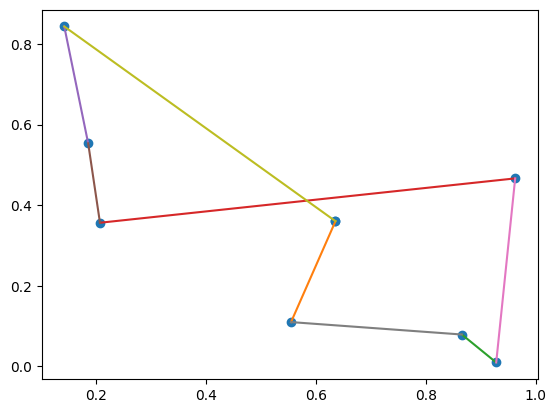

La distancia recorrida por el camino es:  3067.0
El tiempo de la ejecución es de:  174.0248532295227 segundos


In [ ]:
# Dibujamos el camino de la solución
print("Grafo solución")
plt.plot(puntos[:,0],puntos[:,1],'o')
vaux = np.array(list(range(N+1)))
for i in range(N+1):
    sigAux = matSol[i,:]==1
    if np.sum(sigAux) > 0:
        sig = (int(vaux[sigAux][0]))%(N)
        plt.plot(puntos[(i,sig),0],puntos[(i,sig),1])
plt.show()
print("La distancia recorrida por el camino es: ", distanciaSol)
print("El tiempo de la ejecución es de: ", time, "segundos")

A continuación mostraremos la solución en forma de grafo dirigido para así ver el orden en el que se recorren las ciudades. Para ello, creamos esta matriz auxiliar para mostrar el camino en forma de grafo.

In [ ]:
matSol2=matSol
for i in range (N+1):
  if(matSol2[i,N]==1):
    matSol2[i,0]=1
    matSol2[i,N]=0
matSol2=matSol2[:-1,:-1]
matSol2

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]])

[(0, 6), (1, 5), (2, 4), (3, 7), (4, 3), (5, 2), (6, 1), (7, 0)]


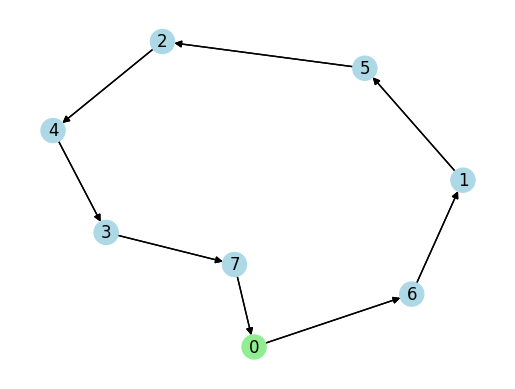

In [ ]:
G = nx.DiGraph()
rows, cols = np.where(matSol2 == 1)
edges = list(zip(rows.tolist(), cols.tolist()))
print(edges)
edges2 = [(x[0], x[1]%len(puntos)) for x in edges]

G.add_edges_from(edges2)
pos2 = nx.spring_layout(G)
nx.draw_networkx_labels(G, pos2)


nx.draw_networkx_edges(G, pos2)

node_colors = ["lightblue" for _ in range(len(G.nodes))]
node_colors[0] = "lightgreen"

nx.draw(G, pos2, node_color = node_colors)
plt.show()